## Import packages

In [1]:
# Enable auto reloading modules (used because of custom local modules)
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
import glob

# Custom local modules
import utils
import ImageFunctions as imgf

%matplotlib inline

## Directories and constants

In [3]:
output_images_dir = os.path.join('..', 'output_images')
test_images_dir = os.path.join('..', 'test_images')

cal_data_file = 'calibration.pickle' # file where to save the distortion coefficients

## Camera distortion

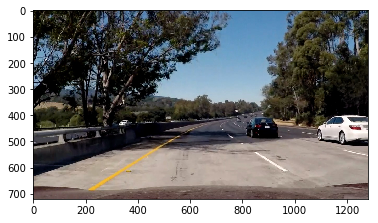

In [4]:
test_image = mpimg.imread(os.path.join(test_images_dir, 'test5.jpg'))
plt.imshow(test_image)

undistorted_image = imgf.undistort(test_image, cal_data_file)

## View color spaces

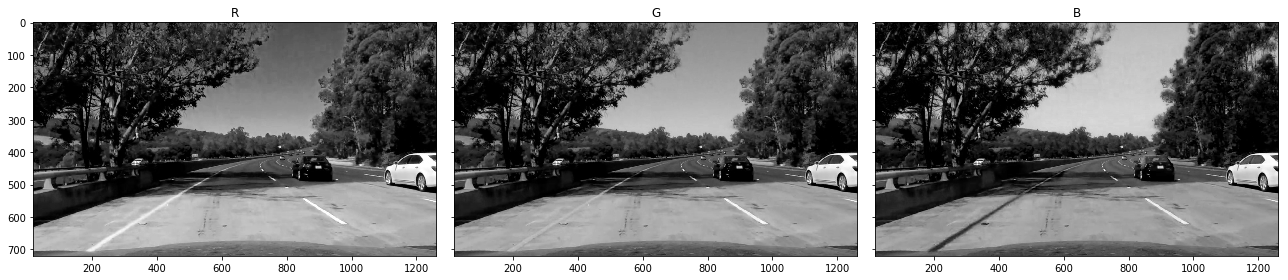

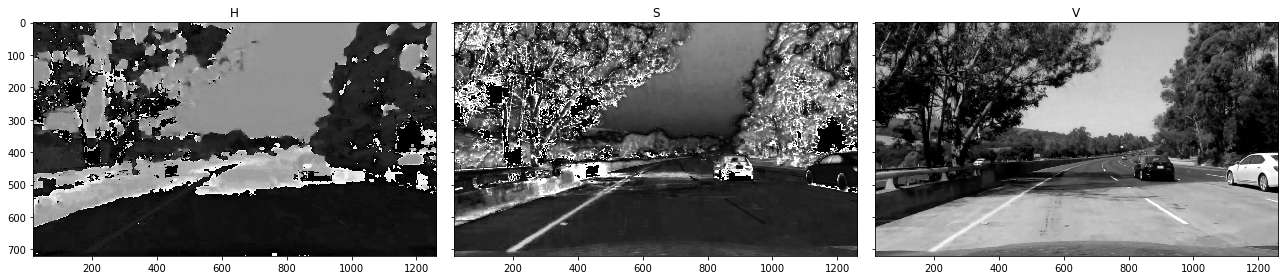

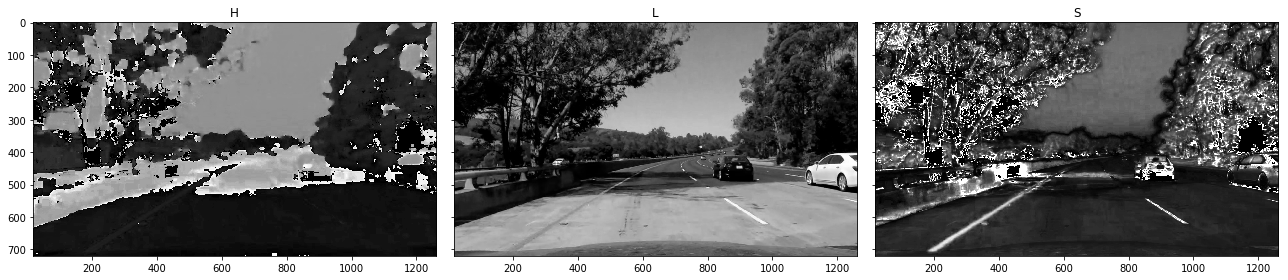

In [5]:
# Display color channels of undistorted image in different color spaces 
utils.plot_color_channels(undistorted_image, labels=['R','G','B'])

hsv_image = imgf.to_hsv(undistorted_image)
utils.plot_color_channels(hsv_image, labels=['H','S','V'])

hls_image = imgf.to_hls(undistorted_image)
fig = utils.plot_color_channels(hls_image, labels=['H','L','S'])

## Apply color thresholds

There are many tools out there to take advantage of HLS color space by helping to find the hue range of specific colors (e.g. https://www.w3schools.com/colors/colors_hsl.asp). For yellow colors the hue angle is approximately between 40° and 70°. However, OpenCV only has a circle up to 180° to fit it in 8 bits (0-255). So, values get divided by 2 which makes a range of 20° to 35° for yellow. I try to use it to apply an appropriate threshold for the H-channel to detect yellow lines. However, the optimized results are not better than the ones from the S-channel which leads me to only using the S-channel to detect them.

For picking up the white lines, the R-channel might be considerable, but as I only want to get white lines more confident than through the S-channel, it shows that a thresholded grayscale image might be preferable because we get less noise and other pixels than white ones.

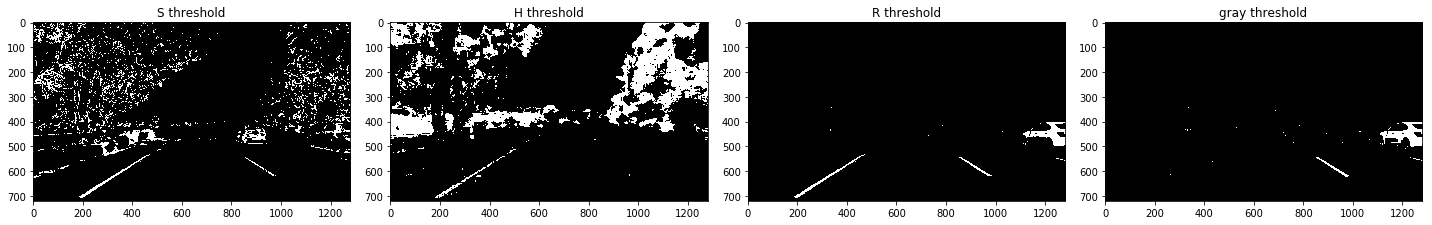

In [6]:
# Applying color thresholds
s_threshold = imgf.color_threshold(hls_image, 2, (170, 255))
h_threshold = imgf.color_threshold(hls_image, 0, (20, 40))
r_threshold = imgf.color_threshold(undistorted_image, 0, (220, 255))

gray_image = imgf.to_grayscale(undistorted_image)
gray_threshold = imgf.color_threshold((np.dstack((gray_image, gray_image, gray_image))), 0, (200, 255))

threshold_images = [s_threshold, h_threshold, r_threshold, gray_threshold]
threshold_labels = ['S threshold', 'H threshold', 'R threshold', 'gray threshold']
fig = utils.plot_images_as_grid(threshold_images, threshold_labels, images_per_row=4, figsize=(20, 4), cmap='gray')

Now I will combine the S-channel with the gray thresholds:

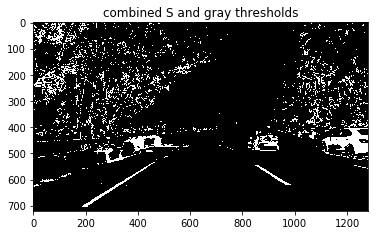

In [7]:
combined_color_thresholds = imgf.combine_binary(s_threshold, gray_threshold)

ax = plt.gca()
ax.set_title('combined S and gray thresholds')
plt.imshow(combined_color_thresholds, cmap='gray')

## Adding gradient thresholds

As the color thresholds especially show a lack of lines in the distance because the color values lose intensity, gradient thresholds will be added with the Sobel-operator to overcome these shortcomings.

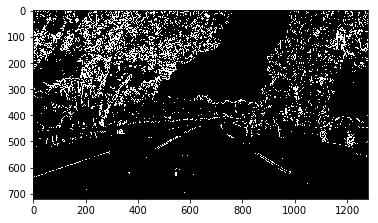

In [8]:
sobel = imgf.sobel_gradient_thresholder(undistorted_image, sobel_kernel=3)
gradient_thresholds = sobel.abs_thresh(orient='x', thresh=(20, 100))
plt.imshow(gradient_thresholds, cmap='gray')

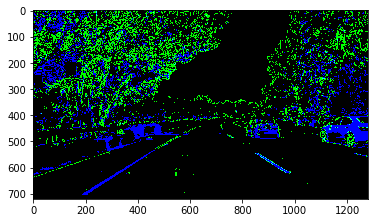

In [9]:
color_binary = np.dstack(( np.zeros_like(gradient_thresholds), gradient_thresholds, combined_color_thresholds)) * 255
plt.imshow(color_binary)

In [10]:
thresholded_image = imgf.combine_binary(gradient_thresholds, combined_color_thresholds)

## Perspective transform

undistorted image size: (1280, 720)
source coordinates:
[[ 600.13086  443.07693]
 [ 681.86914  443.07693]
 [1137.7778   720.     ]
 [ 182.22223  720.     ]]
destination coordinates:
[[ 182.22223    0.     ]
 [1137.7778     0.     ]
 [1137.7778   720.     ]
 [ 182.22223  720.     ]]


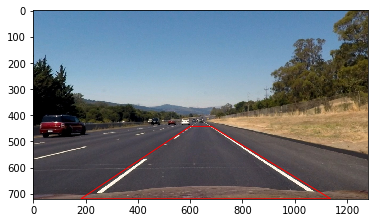

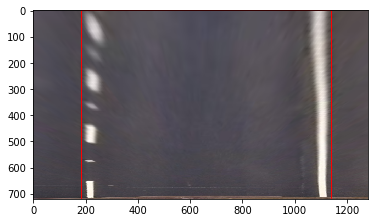

In [148]:
straight_image = mpimg.imread(os.path.join(test_images_dir, 'straight_lines2.jpg'))
undistorted_straight_image = imgf.undistort(straight_image, cal_data_file)

image_size = undistorted_straight_image.shape[1], undistorted_straight_image.shape[0]
print(f'undistorted image size: {image_size}')

top_y = image_size[1]-image_size[1]/2.6
bottom_y = image_size[1]

bottom_x_margin = image_size[0]/9
bottom_left_x = 40+bottom_x_margin
bottom_right_x = image_size[0]-bottom_x_margin

top_x_margin = image_size[0]/2.14
top_left_x = top_x_margin+2
top_right_x = image_size[0]-top_x_margin

dst_left_x = bottom_left_x
dst_right_x = bottom_right_x

trans_src = np.float32([
    [top_left_x, top_y],        # top-left
    [top_right_x, top_y],       # top-right
    [bottom_right_x, bottom_y], # bottom-right
    [bottom_left_x, bottom_y],  # bottom-left
])
trans_dst = np.float32([
    [dst_left_x, 0],              # top-left
    [dst_right_x, 0],             # top-right
    [dst_right_x, image_size[1]], # bottom-right
    [dst_left_x, image_size[1]]   # bottom-left
])
trans_straight_image = imgf.transform_perspective(undistorted_straight_image, trans_src, trans_dst)

plt.imshow(undistorted_straight_image)
plt.fill(trans_src[:,0], trans_src[:,1]-.5, edgecolor='r', fill=False)

plt.figure()
plt.imshow(trans_straight_image)
plt.fill(trans_dst[:,0], trans_dst[:,1]-.5, edgecolor='r', fill=False)

print('source coordinates:')
print(trans_src)
print('destination coordinates:')
print(trans_dst)

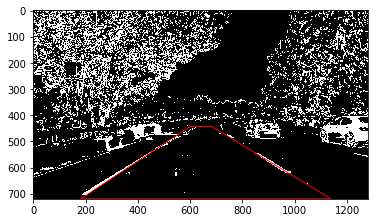

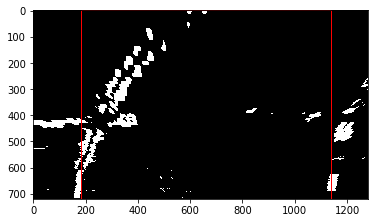

In [149]:
plt.imshow(thresholded_image, cmap='gray')
plt.fill(trans_src[:,0], trans_src[:,1]-.5, edgecolor='r', fill=False)

plt.figure()
trans_image = imgf.transform_perspective(thresholded_image, trans_src, trans_dst)
plt.imshow(trans_image, cmap='gray')
plt.fill(trans_dst[:,0], trans_dst[:,1]-.5, edgecolor='r', fill=False)